## Packages

In [37]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import os

import collections
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import cleanlab
from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import print_noise_matrix
from cleanlab import baseline_methods
from cleanlab.latent_estimation import compute_confident_joint
from cleanlab import baseline_methods
from cleanlab.latent_estimation import compute_confident_joint

In [38]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def acc_loss_plot(network):
    accuracy = network.history['accuracy']
    val_accuracy = network.history['val_accuracy']
    loss = network.history['loss']
    val_loss = network.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'c', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

## Lectura de les dades

In [39]:
print(tf. __version__)

2.6.0


In [40]:
os.getcwd()

'C:\\Users\\aidaf\\TFG'

In [41]:
data_dir = os.path.join(os.getcwd() + "\\reduced")
data_dir

'C:\\Users\\aidaf\\TFG\\reduced'

In [42]:
classes = os. listdir(data_dir)
print(classes)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [43]:
dades_Y = np.load('labels_reduced.npy')
dades_X = np.load('images_reduced.npy')

dades_Y.shape, dades_X.shape

((4500,), (4500, 120, 120, 3))

In [44]:
clean_Y = np.load('labels_reduced_clean.npy')
clean_X = np.load('images_reduced_clean.npy')

clean_X.shape, clean_Y.shape

((500, 120, 120, 3), (500,))

## Descripció de les dades

In [45]:
dades_Y_clean, dades_Y_resta = dades_Y[0:500], dades_Y[500:4500]
dades_X_clean, dades_X_resta = dades_X[0:500,], dades_X[500:4500,]

Dimensió: 

In [46]:
print('Dimensions de les dades : ', dades_X_clean.shape, dades_Y_clean.shape)
print('Dimensions de les dades : ', dades_X_resta.shape, dades_Y_resta.shape)

Dimensions de les dades :  (500, 120, 120, 3) (500,)
Dimensions de les dades :  (4000, 120, 120, 3) (4000,)


Nombre de classes i etiquetes: 

In [47]:
n_classes = len(classes)
print('Nombre de classes : ', n_classes)
print('Etiquetes de les classes : ', classes)

Nombre de classes :  5
Etiquetes de les classes :  ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


Distribució de les classes: 

In [48]:
print("Distribució de les classes : ",collections.Counter(dades_Y_clean))
print("Distribució de les classes : ",collections.Counter(dades_Y_resta))

Distribució de les classes :  Counter({0: 114, 3: 101, 1: 100, 2: 93, 4: 92})
Distribució de les classes :  Counter({4: 808, 2: 807, 1: 800, 3: 799, 0: 786})


# Augmentem encara més el soroll

In [16]:
noise_matrix = np.array([[.54,.34,.06,.03,.03],
                         [.39,.50,.03,.03,.05],
                         [.10,.01,.25,.34,.30],
                         [.08,.01,.12,.66,.13],
                         [.08,.08,.13,.15,.56]])

np.sum(noise_matrix,1)

array([1., 1., 1., 1., 1.])

In [17]:
print_noise_matrix(noise_matrix)
np.random.seed(seed=1)
# Create the noisy labels. This method is exact w.r.t. the noise_matrix.
y_train_w_errors = generate_noisy_labels(dades_Y_resta, noise_matrix)


print("------------------------------------------------------")
print("% d'etiquetes netes: ",sum(y_train_w_errors == dades_Y_resta)/len(dades_Y_resta))

print("------------------------------------------------------")

dades_Y_one_hot = np.array(pd.get_dummies(dades_Y_clean))
dades_Y_one_hot = dades_Y_one_hot.astype('float32')

train_X,valid_X,train_label,valid_label = train_test_split(dades_X_clean, dades_Y_one_hot, test_size=0.1, 
                                                           random_state=13,stratify=dades_Y_one_hot)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(y_train_w_errors))


 Noise Matrix (aka Noisy Channel) P(s|y) of shape (5, 5)
 p(s|y)	y=0	y=1	y=2	y=3	y=4
	---	---	---	---	---
s=0 |	0.54	0.34	0.06	0.03	0.03
s=1 |	0.39	0.5	0.03	0.03	0.05
s=2 |	0.1	0.01	0.25	0.34	0.3
s=3 |	0.08	0.01	0.12	0.66	0.13
s=4 |	0.08	0.08	0.13	0.15	0.56
	Trace(matrix) = 2.51

------------------------------------------------------
% d'etiquetes netes:  0.50525
------------------------------------------------------
(450, 120, 120, 3) (50, 120, 120, 3) (450, 5) (50, 5)
------------------------------------------------------
Distribució de les classes :  Counter({2: 1134, 1: 841, 4: 746, 0: 645, 3: 634})


In [25]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(dades_X_clean.shape[1],dades_X_clean.shape[2],3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(n_classes, activation='softmax'))

# fit model on the augmented dataset
# initialize the number of epochs and batch size
EPOCHS = 20
BS = 32

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [26]:
# train the network
H = model.fit(train_X, train_label, batch_size=BS, epochs=EPOCHS,
              verbose=1, validation_data=(valid_X, valid_label))

Epoch 1/20
15/15 [==============================] - 18s 1s/step - loss: 3.9499 - accuracy: 0.2978 - val_loss: 1.0847 - val_accuracy: 0.4400
Epoch 2/20
15/15 [==============================] - 16s 1s/step - loss: 1.0093 - accuracy: 0.4978 - val_loss: 0.7336 - val_accuracy: 0.7000
Epoch 3/20
15/15 [==============================] - 14s 935ms/step - loss: 0.8910 - accuracy: 0.5933 - val_loss: 1.0621 - val_accuracy: 0.4000
Epoch 4/20
15/15 [==============================] - 13s 864ms/step - loss: 0.8763 - accuracy: 0.6000 - val_loss: 0.7315 - val_accuracy: 0.6600
Epoch 5/20
15/15 [==============================] - 13s 885ms/step - loss: 0.6556 - accuracy: 0.6889 - val_loss: 0.8594 - val_accuracy: 0.5400
Epoch 6/20
15/15 [==============================] - 15s 966ms/step - loss: 0.6116 - accuracy: 0.7289 - val_loss: 0.5242 - val_accuracy: 0.7400
Epoch 7/20
15/15 [==============================] - 13s 878ms/step - loss: 0.4515 - accuracy: 0.8111 - val_loss: 0.4287 - val_accuracy: 0.8600
Epoch

In [27]:
model.save("model_50_500.h5")

In [49]:
def_model = keras.models.load_model('model_50_500.h5')
test_eval = def_model.evaluate(valid_X,valid_label, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.19686481356620789
Test accuracy: 0.922879159450531


In [50]:
predicted_classes = def_model.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels = np.argmax(np.round(valid_label),axis=1)

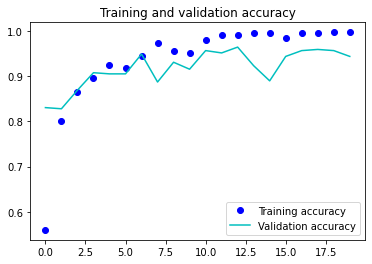

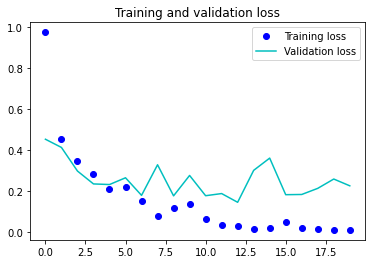

In [51]:
acc_loss_plot(H)

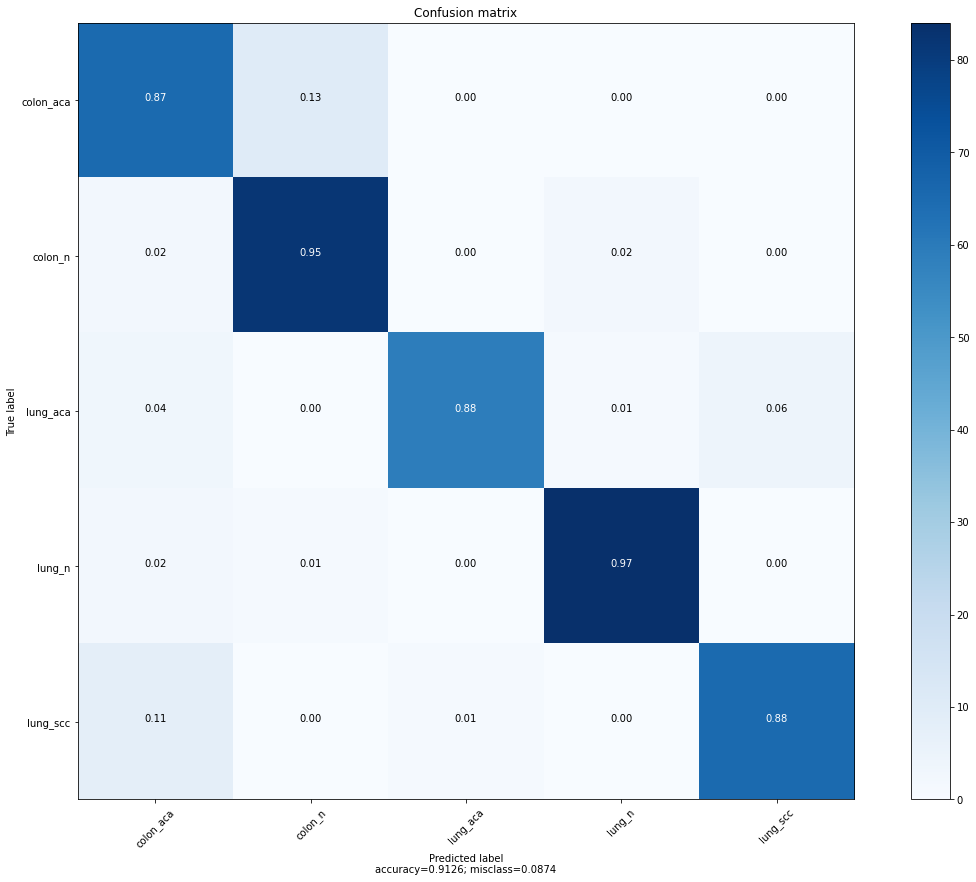

In [52]:
plot_confusion_matrix(confusion_matrix(valid_labels, predicted_classes), target_names = classes)

In [53]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.81      0.87      0.84        75
     colon_n       0.88      0.95      0.92        86
    lung_aca       0.98      0.88      0.93        67
      lung_n       0.97      0.97      0.97        87
    lung_scc       0.94      0.88      0.91        74

    accuracy                           0.91       389
   macro avg       0.92      0.91      0.91       389
weighted avg       0.92      0.91      0.91       389



## Demanem al model que digui quines prediccions són errónies

In [54]:
prediccions = def_model.predict(dades_X_resta)

In [55]:
s = dades_Y_resta
psx = prediccions

In [56]:
label_error_mask = np.zeros(len(s), dtype=bool)
label_error_indices = compute_confident_joint(
    s, psx, return_indices_of_off_diagonals=True)[1]
baseline_conf_joint_only = label_error_mask    

# Method: C_confusion
baseline_argmax = baseline_methods.baseline_argmax(psx, s)

# Method: CL: PBC
baseline_cl_pbc = cleanlab.pruning.get_noise_indices(
    s, psx, prune_method='prune_by_class')

# ethod: CL: PBNR
baseline_cl_pbnr = cleanlab.pruning.get_noise_indices(
            s, psx, prune_method='prune_by_noise_rate')

# Method: CL: C+NR
baseline_cl_both = cleanlab.pruning.get_noise_indices(
    s, psx, prune_method='both')

clean_labels = {
        'conf_joint_only': ~baseline_conf_joint_only,
        'pruned_argmax': ~baseline_argmax,
        'cl_pbc': ~baseline_cl_pbc,
        'cl_pbnr': ~baseline_cl_pbnr,
        'cl_both': ~baseline_cl_both,
    }

In [57]:
aux = ((((baseline_conf_joint_only==baseline_argmax)
         ==(baseline_argmax==baseline_cl_pbc))
         ==((baseline_cl_pbc==baseline_cl_pbnr)
         ==(baseline_cl_pbnr==baseline_cl_both)))
         ==(baseline_cl_both==baseline_cl_pbnr))

In [58]:
sum(aux), sum(aux)/len(aux)

(3383, 0.84575)

In [59]:
X_defs = dades_X_resta[aux]
Y_defs = dades_Y_resta[aux]

print(X_defs.shape,Y_defs.shape)

(3383, 120, 120, 3) (3383,)


In [60]:
new_Y = np.concatenate((dades_Y_clean, Y_defs),axis = 0)
new_X = np.concatenate((dades_X_clean, X_defs),axis = 0)

print(new_X.shape,new_Y.shape)

(3883, 120, 120, 3) (3883,)


In [61]:
dades_Y_one_hot = np.array(pd.get_dummies(new_Y))
dades_Y_one_hot = dades_Y_one_hot.astype('float32')

train_X,valid_X,train_label,valid_label = train_test_split(new_X, dades_Y_one_hot, test_size=0.1, 
                                                           random_state=13,stratify=new_Y)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(new_Y))

(3494, 120, 120, 3) (389, 120, 120, 3) (3494, 5) (389, 5)
------------------------------------------------------
Distribució de les classes :  Counter({3: 873, 1: 854, 0: 745, 4: 741, 2: 670})


In [62]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(dades_X_clean.shape[1],dades_X_clean.shape[2],3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

# fit model on the augmented dataset
# initialize the number of epochs and batch size
EPOCHS = 20
BS = 64

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [63]:
# train the network
H = model.fit(train_X, train_label, batch_size=BS, epochs=EPOCHS,
              verbose=1, validation_data=(valid_X, valid_label))

Epoch 1/20
55/55 [==============================] - 387s 7s/step - loss: 1.2325 - accuracy: 0.5031 - val_loss: 0.5739 - val_accuracy: 0.7661
Epoch 2/20
55/55 [==============================] - 335s 6s/step - loss: 0.5730 - accuracy: 0.7562 - val_loss: 0.4145 - val_accuracy: 0.8278
Epoch 3/20
55/55 [==============================] - 355s 6s/step - loss: 0.4343 - accuracy: 0.8214 - val_loss: 0.4314 - val_accuracy: 0.8123
Epoch 4/20
55/55 [==============================] - 438s 8s/step - loss: 0.3779 - accuracy: 0.8429 - val_loss: 0.3073 - val_accuracy: 0.8560
Epoch 5/20
55/55 [==============================] - 491s 9s/step - loss: 0.2774 - accuracy: 0.8958 - val_loss: 0.3688 - val_accuracy: 0.8560
Epoch 6/20
55/55 [==============================] - 400s 7s/step - loss: 0.2185 - accuracy: 0.9141 - val_loss: 0.2001 - val_accuracy: 0.9280
Epoch 7/20
55/55 [==============================] - 419s 8s/step - loss: 0.1606 - accuracy: 0.9410 - val_loss: 0.1959 - val_accuracy: 0.9306
Epoch 8/20
55

In [64]:
model.save("model_50_500_defs.h5")

In [65]:
def_model_2 = keras.models.load_model('model_50_500_defs.h5')
test_eval = def_model_2.evaluate(valid_X,valid_label, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.24061450362205505
Test accuracy: 0.9460154175758362


In [66]:
predicted_classes = def_model_2.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels = np.argmax(np.round(valid_label),axis=1)

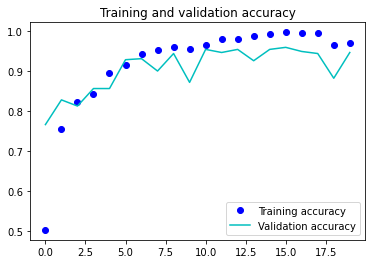

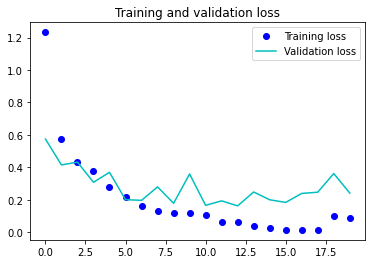

In [67]:
acc_loss_plot(H)

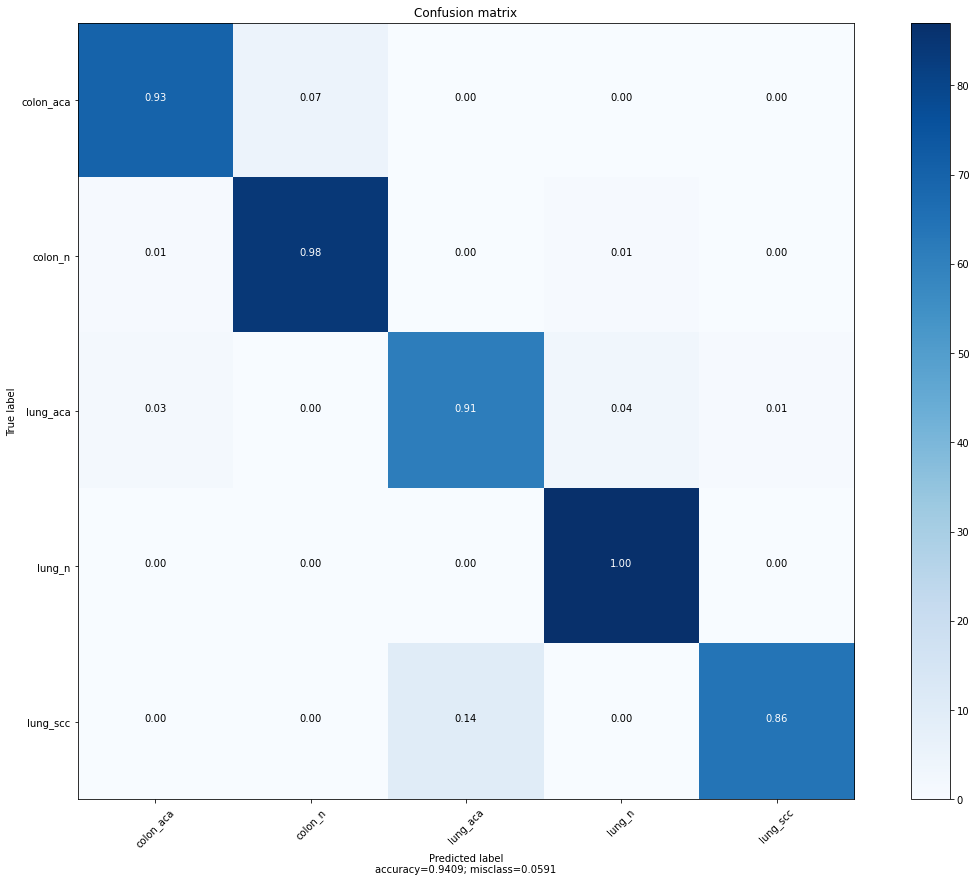

In [68]:
plot_confusion_matrix(confusion_matrix(valid_labels, predicted_classes), target_names = classes)

In [69]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.96      0.93      0.95        75
     colon_n       0.94      0.98      0.96        86
    lung_aca       0.86      0.91      0.88        67
      lung_n       0.96      1.00      0.98        87
    lung_scc       0.98      0.86      0.92        74

    accuracy                           0.94       389
   macro avg       0.94      0.94      0.94       389
weighted avg       0.94      0.94      0.94       389



### Comprovem com va classificar el model inicial entrenat amb les dades errònies

In [70]:
def_model_defs = keras.models.load_model('model_50_500_defs.h5')

In [71]:
prediction = def_model_defs.predict(clean_X)
pred_labs_defs = []

for i in range(len(prediction)):
    pred_labs_defs.append(np.argmax(prediction[i]))

In [72]:
sum(pred_labs_defs == clean_Y)/len(clean_Y)

0.862